# Energy resolution plots for CLUE3D, CLUE, Rechits

In [1]:
import sys
from collections import namedtuple
import numpy as np
from uncertainties import ufloat, unumpy
import uncertainties
import scipy
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("../..")
from HistogramLib.store import HistogramStore
from HistogramLib.plot_manager import PlotManager
from HistogramLib.bokeh.histogram_widget import *
from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
from hists.store import HistogramId
from bokeh_apps.widgets import *

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v33'
histStore = HistogramStore(hist_folder, HistogramId)

In [3]:
h1 = histStore.get(HistogramId("RechitsTotalEnergyPerEvent", "cmssw", "data")).getHistogram(HistogramKind.COUNT)
h1[{"beamEnergy":hist.loc(20), "rechits_energy_sum":slice(hist.loc(15), hist.loc(30))}]

Hist(Regular(86, 14.875, 29.925, name='rechits_energy_sum', label='Total reconstructed energy per event (GeV)'), storage=Double()) # Sum: 19432.0 (19969.0 with flow)

In [4]:
from hist.plot import _fit_callable_to_hist, _construct_gaussian_callable
from hist import loc, rebin
FitResult = namedtuple("FitResult", ["mean", "sigma"])
def doFit(h:hist.Hist, beamEnergy, simulationName="", makePlot=False):
    narrow_window = h[loc(0.7*beamEnergy):loc(1.1*beamEnergy)]
    gaussian = _construct_gaussian_callable(narrow_window)
    (
        _,_,_,
        bestfit_result
    )  = _fit_callable_to_hist(gaussian, narrow_window, likelihood=True)
    ((norm, mean, sigma), _) = bestfit_result

    sigma = abs(sigma) # For some reason negative sigma happens
    exception = None
    try:
        narrow_window = h[loc(mean - 1.5*sigma):loc(mean+1.5*sigma)]
        gaussian = _construct_gaussian_callable(narrow_window)
        (
            _,_,_,
            bestfit_result
        )  = _fit_callable_to_hist(gaussian, narrow_window, likelihood=True)
        ((norm, mean, sigma), covarianceMatrix) = bestfit_result
    except ValueError as e:
        exception = e
    sigma = abs(sigma) # For some reason negative sigma happens

    if makePlot:
        fitResultArtists, ratiolikeArtists = narrow_window.plot_pull("gaus", likelihood=True, fit_fmt=r"{name} = {value:.4g} $\pm$ {error:.3g}")
        plt.xlabel("Energy reconstrcuted per event (GeV)")
        if len(simulationName) == 0:
            hep.cms.text("Preliminary", ax=fitResultArtists.line.axes)
            hep.cms.lumitext("$e^+$ " + str(beamEnergy) + " GeV", ax=fitResultArtists.line.axes)
        else:
            hep.cms.text("Preliminary Simulation", ax=fitResultArtists.line.axes, fontsize=24)
            hep.cms.lumitext("$e^+$ " + str(beamEnergy) + " GeV ("+simulationName+")", ax=fitResultArtists.line.axes, fontsize=20)
        
    if exception is not None:
        raise exception
    mean_u, sigma_u = uncertainties.correlated_values([mean, sigma], covarianceMatrix[1:, 1:]) # remove norm from covariance matrix
    return FitResult(mean_u, sigma_u)



In [5]:
def getClue3DProjected(datatype, beamEnergy):
    return (
        histStore.get(HistogramId("Clus3DClusteredEnergy", "cmssw", datatype))
        .getHistogram(HistogramKind.COUNT)
        [{"beamEnergy":hist.loc(beamEnergy), "mainOrAllTracksters":hist.loc("mainTrackster")}]
        .project("clus3D_energy")
    )
def getClue2DProjected(datatype, beamEnergy):
    return (
        histStore.get(HistogramId("EnergyClustered2DPerEvent", "cmssw", datatype))
        .getHistogram(HistogramKind.COUNT)
        [{"beamEnergy":hist.loc(beamEnergy)}]
        .project("clus2D_energy_sum")
    )
def getRechitsProjected(datatype, beamEnergy):
    return (
        histStore.get(HistogramId("RechitsTotalEnergyPerEvent", "cmssw", datatype))
        .getHistogram(HistogramKind.COUNT)
        [{"beamEnergy":hist.loc(beamEnergy)}]
        .project("rechits_energy_sum")
    )

FitResult(mean=100.73587361709725+/-0.015293300918727716, sigma=2.381821060168796+/-0.01352799621319966)

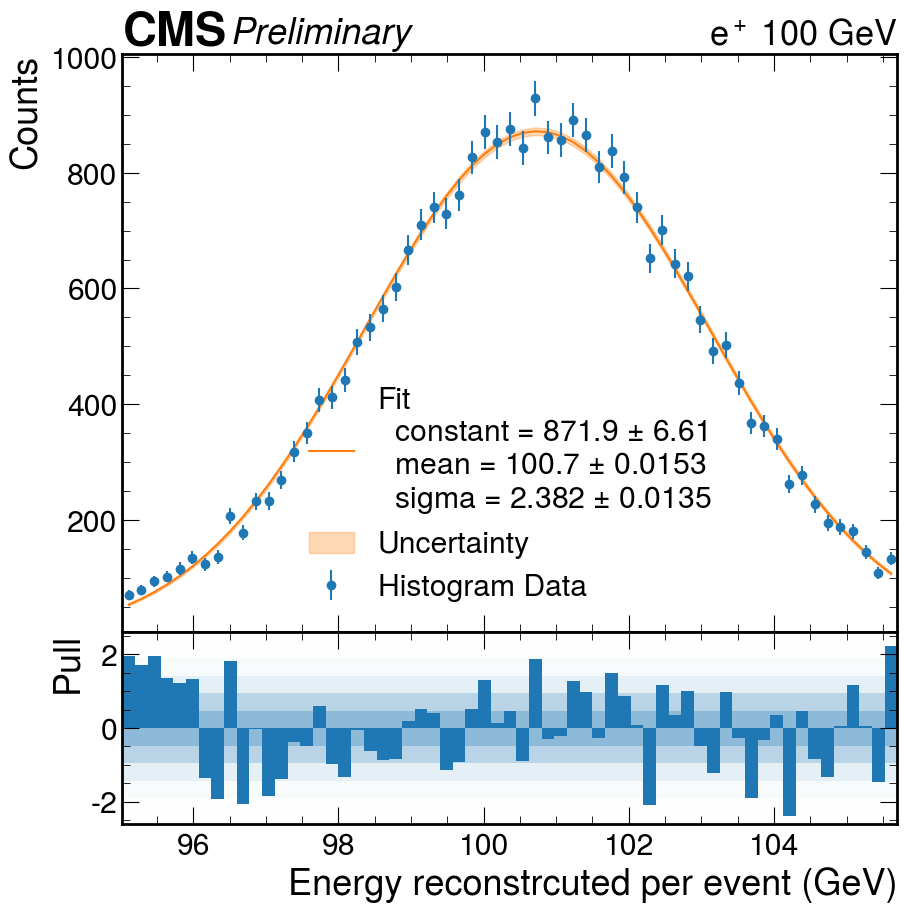

In [6]:
doFit(h1[{"beamEnergy":hist.loc(100)}], 100, makePlot=True)

In [7]:
# dict data/sim -> rechit/clue/clue3D -> beamEnergy -> tuple mean, sigma
def doAllFits(datatype:str) -> dict:
    dict_res = {}
    for level, loadHistFct in {"rechit":getRechitsProjected, "clue":getClue2DProjected, "clue3D":getClue3DProjected}.items():
        dict_res[level] = {}
        for beamEnergy in beamEnergies:
            h = loadHistFct(datatype, beamEnergy)
            dict_res[level][beamEnergy] = doFit(h, beamEnergy, makePlot=False)
    return dict_res

In [8]:
fitResults = {datatype : doAllFits(datatype) for datatype in ["data", "sim_proton_v46_patchMIP"]}

In [9]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [10]:
levelLabelMap = {"rechit":"Rechits", "clue":"CLUE", "clue3D":"CLUE3D", "paper" : "JINST paper"}
#levelColorMap = {"rechit":"blue", "clue":"yellow", "clue3D":"green"}
levelColorMap = {"rechit":"#1f77b4", "clue":"#ff7f0e", "clue3D":"#2ca02c", "paper":"#d62728"}
def addLumiLegend(main_ax, datatypes, beamEnergy):
    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    hep.cms.lumitext(f"$e^+$ {str(beamEnergy)} GeV", ax=main_ax)
    main_ax.legend()

def plotMean(datatype_dict:dict, ax:plt.Axes=None, normByRechits=False, errors=False):
    if ax is None:
        fig, ax = plt.subplots()
    
    if normByRechits:
        datatype_dict = datatype_dict.copy()
        rechits_dict = datatype_dict.pop("rechit")
        
        plot_dict = {level : np.array([level_dict[beamEnergy].mean / rechits_dict[beamEnergy].mean for beamEnergy in beamEnergies]) 
            for level, level_dict in datatype_dict.items()}
        ax.set_ylabel("$\\frac{<E>}{<E_{rechits}>}$")

    else:
        plot_dict = {level : np.array([level_dict[beamEnergy].mean / synchrotronBeamEnergiesMap[beamEnergy] for beamEnergy in beamEnergies]) 
            for level, level_dict in datatype_dict.items()}
        ax.set_ylabel("$\\frac{<E>}{E_{beam}}$")
    
    xValues = [synchrotronBeamEnergiesMap[beamEnergy] for beamEnergy in beamEnergies]
    for level, plot_level_values in plot_dict.items():
        if errors:
            ax.errorbar(xValues, unumpy.nominal_values(plot_level_values), yerr=unumpy.std_devs(plot_level_values),
                fmt='-', label=levelLabelMap[level])
        else:
            ax.plot(xValues, unumpy.nominal_values(plot_level_values), 'o-', label=levelLabelMap[level])
    
    ax.set_xlabel("Beam energy (incl. synchroton losses) (GeV)")
    
    ax.axhline(y=1, linestyle="--", color="black")
    hep.cms.text("Preliminary", ax=ax)
    hep.cms.lumitext(f"$e^+$ test beam", ax=ax)
    ax.legend()

In [11]:
fitResults["data"]["rechit"]

{20: FitResult(mean=19.641905925626542+/-0.008776293549424304, sigma=0.9400286542990448+/-0.009416009761239637),
 30: FitResult(mean=29.507621100836708+/-0.011062181652291576, sigma=1.1685510472432505+/-0.012750764363377515),
 50: FitResult(mean=49.85185847469547+/-0.008078360287630445, sigma=1.5452727982906989+/-0.008529456837129506),
 80: FitResult(mean=80.35469318637313+/-0.011909571359607914, sigma=2.0290401851197912+/-0.01312800095646354),
 100: FitResult(mean=100.73587361709725+/-0.015293300918727716, sigma=2.381821060168796+/-0.01352799621319966),
 120: FitResult(mean=121.18230551903287+/-0.01872087426286297, sigma=2.511467229577294+/-0.017699687177630784),
 150: FitResult(mean=151.05279516722743+/-0.017340326992935872, sigma=2.8199318813962324+/-0.014672811555087654),
 200: FitResult(mean=199.80823991668305+/-0.027696802723768017, sigma=3.270374192029659+/-0.024458446885268412),
 250: FitResult(mean=245.92692354291762+/-0.030355351153715442, sigma=3.6332279348626013+/-0.0258989

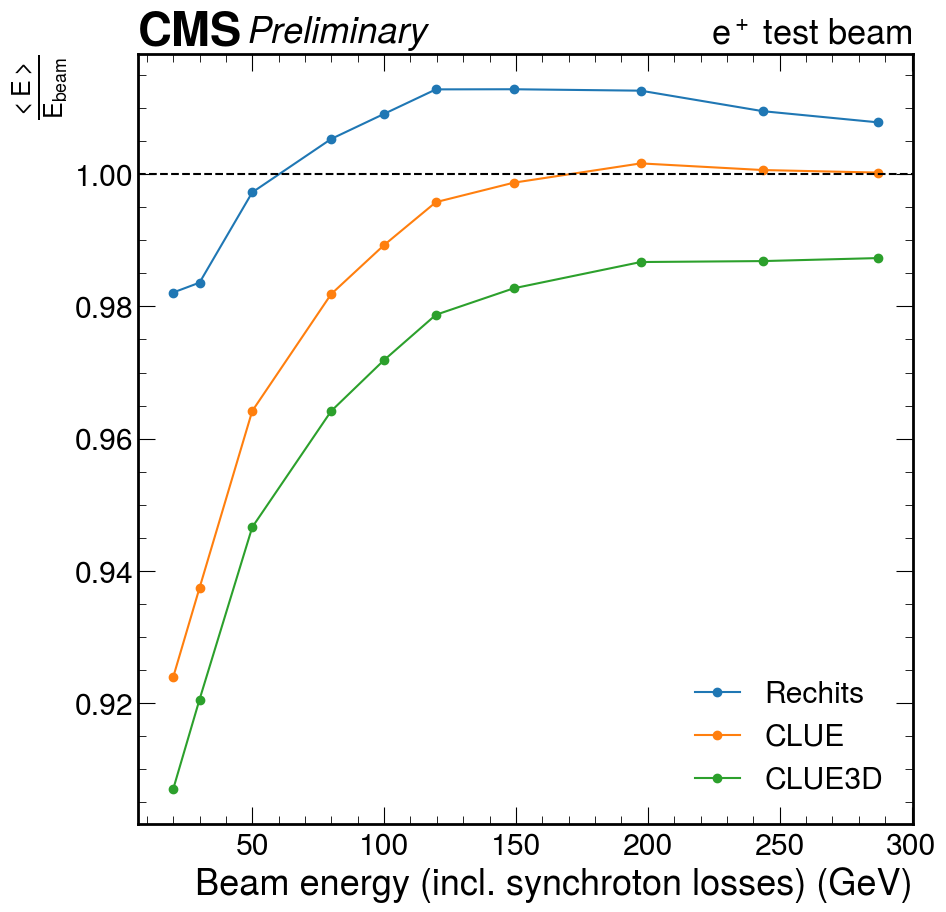

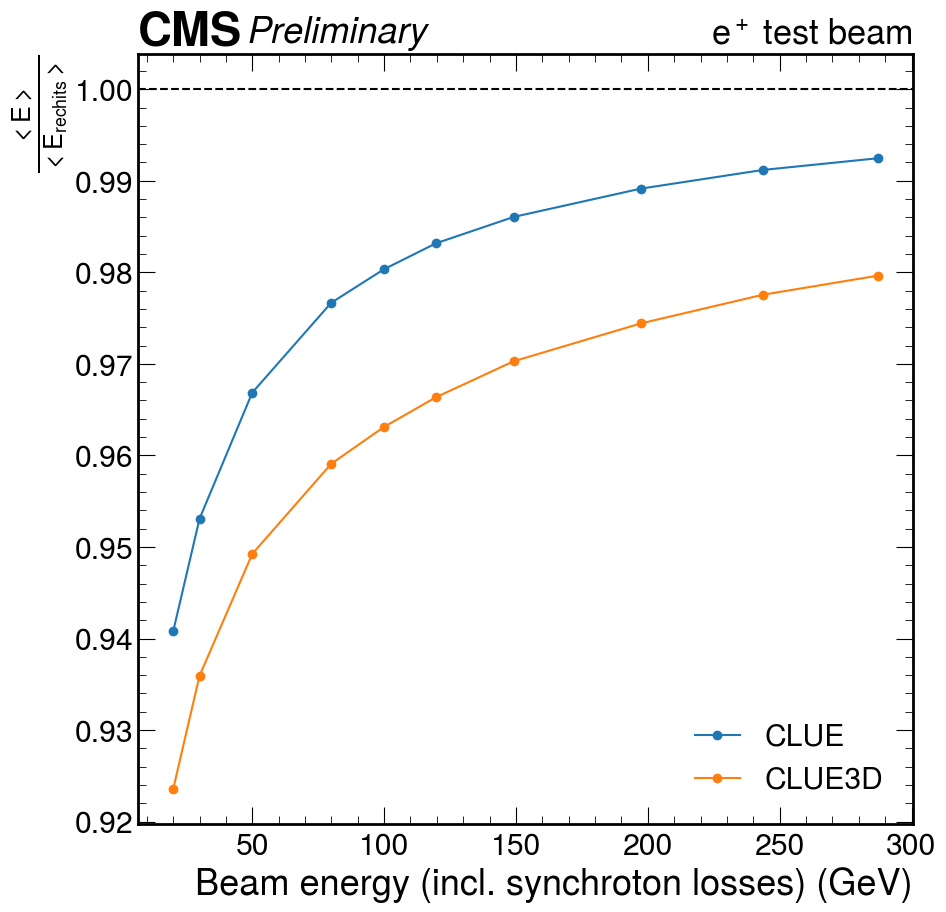

In [12]:
plotMean(fitResults["data"], errors=False)
plotMean(fitResults["data"], normByRechits=True, errors=False)

In [26]:
EResolutionFitResult = namedtuple("EResolutionFitResult", ["S", "C"])
# From JINST paper (https://arxiv.org/abs/2111.06855), table 3, dEdx method
paperResolution_data = EResolutionFitResult(S=uncertainties.ufloat(22, 0.3)/100, C=uncertainties.ufloat(0.53, 0.09)/100)
paperResolution_sim = EResolutionFitResult(S=uncertainties.ufloat(21.3, 0.3)/100, C=uncertainties.ufloat(0.55, 0.07)/100)

def fitFunction(x, S, C):
    return np.sqrt((x*S)**2 + C**2)
def fit(level_dict:dict):
    """ level_dict : dict beamEnergy -> FittedResult """
    yValues = np.array([level_dict[beamEnergy].sigma / level_dict[beamEnergy].mean for beamEnergy in beamEnergies])
    (S, C), covMatrix = scipy.optimize.curve_fit(fitFunction, 
        xdata=[1/math.sqrt(synchrotronBeamEnergiesMap[beamEnergy]) for beamEnergy in beamEnergies],
        ydata=unumpy.nominal_values(yValues), sigma=unumpy.std_devs(yValues),
        p0=[22., 0.6],
        absolute_sigma=True, # not entirely sure this is correct
    )
    (S, C) = uncertainties.correlated_values([S, C], covMatrix)
    return EResolutionFitResult(S, C)

def plotSigmaOverMean(datatype_dict:dict, ax:plt.Axes=None, xMode="E", errors=True, plotFit=False, sim=False, plotPaperFit=False, linkPointsWithLines=True, markersize=5):
    """ xmode is "E" or "1/sqrt(E)" """
    if ax is None:
        fig, ax = plt.subplots()
    
    plot_dict = {level : np.array([level_dict[beamEnergy].sigma / level_dict[beamEnergy].mean for beamEnergy in beamEnergies]) 
        for level, level_dict in datatype_dict.items()}
    
    if xMode == "E":
        ax.set_xlabel("Beam energy (incl. synchroton losses) (GeV)")
        xValues = [synchrotronBeamEnergiesMap[beamEnergy] for beamEnergy in beamEnergies]
    elif xMode == "1/sqrt(E)":
        ax.set_xlabel(r"$\frac{1}{\sqrt{E_{beam} [GeV]}}$")
        xValues = [1/math.sqrt(synchrotronBeamEnergiesMap[beamEnergy]) for beamEnergy in beamEnergies]
    else:
        assert(False)

    handles = []
    for level, plot_level_values in plot_dict.items():
        markerArgs = dict(marker='o', markersize=markersize, fillstyle="full")
        if not linkPointsWithLines:
            markerArgs["linestyle"] = "none"
        if errors:
            h = ax.errorbar(xValues, unumpy.nominal_values(plot_level_values), 
                yerr=unumpy.std_devs(plot_level_values), label=levelLabelMap[level], color=levelColorMap[level], **markerArgs)
        else:
            h = ax.plot(xValues, unumpy.nominal_values(plot_level_values),
                label=levelLabelMap[level], color=levelColorMap[level], **markerArgs)[0]
        handles.append(h)
        # Doing the fit
        fitRes = fit(datatype_dict[level])
        if xMode == "1/sqrt(E)":
            fitFctBound = functools.partial(fitFunction, S=fitRes.S.nominal_value, C=fitRes.C.nominal_value)
            linestyle = '--' if plotFit else "None"
            h = ax.axline((xValues[0], fitFctBound(xValues[0])), (xValues[-1], fitFctBound(xValues[-1])),
                linestyle=linestyle, color=levelColorMap[level],
                label=f"$S = ({fitRes.S*100:L})" r"\sqrt{GeV} \%$" "\n" f"$C = ({fitRes.C*100:L}) \%$")
            handles.append(h)

    if plotPaperFit:
        if xMode != "1/sqrt(E)":
            raise ValueError("pltoPaperFit only in 1/sqrt(E) mode")
        if sim:
            fitRes = paperResolution_sim
        else:
            fitRes = paperResolution_data
        color = levelColorMap["paper"]
        #handles.append(ax.plot([], [], label=("JINST paper ("+("Simulation" if sim else "Data")+")"), 
        #    color=color, linestyle="none")[0])
        #paperLabel = "JINST paper ("+("Simulation" if sim else "Data")+")"
        paperLabel = levelLabelMap["paper"]
        fitFctBound = functools.partial(fitFunction, S=fitRes.S.nominal_value, C=fitRes.C.nominal_value)
        linestyle = '--' if plotFit else "None"
        h = ax.axline((xValues[0], fitFctBound(xValues[0])), (xValues[-1], fitFctBound(xValues[-1])),
            linestyle=linestyle, color=color,
            label=paperLabel +"\n" + f"$S = ({fitRes.S*100:L})" r"\sqrt{GeV} \%$" "\n" f"$C = ({fitRes.C*100:L}) \%$")
        handles.append(h)

    ax.set_ylabel("$\\frac{\sigma_E}{<E>}$")
    if sim:
        hep.cms.text("Simulation Preliminary", ax=ax)
    else:
        hep.cms.text("Preliminary", ax=ax)
    hep.cms.lumitext(f"$e^+$ test beam", ax=ax)
    
    legend_kwargs = dict(frameon=True, handletextpad=0.3)
    if plotPaperFit:
        ax.add_artist(ax.legend(handles=handles[:2]+handles[-1:], loc="upper left", **legend_kwargs))
        ax.legend(handles=handles[2:-1], loc="lower right", **legend_kwargs)

    else:
        ax.add_artist(ax.legend(handles=handles[:2], loc="upper left", **legend_kwargs))
        ax.legend(handles=handles[2:], loc="lower right", **legend_kwargs)

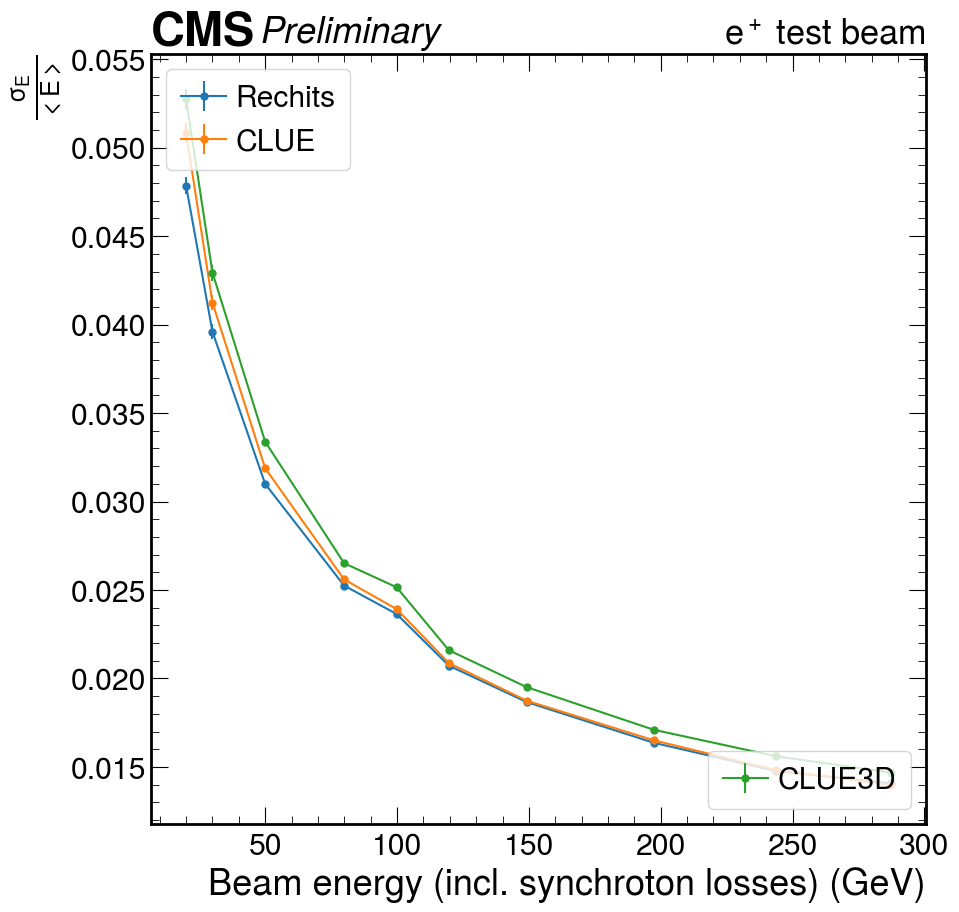

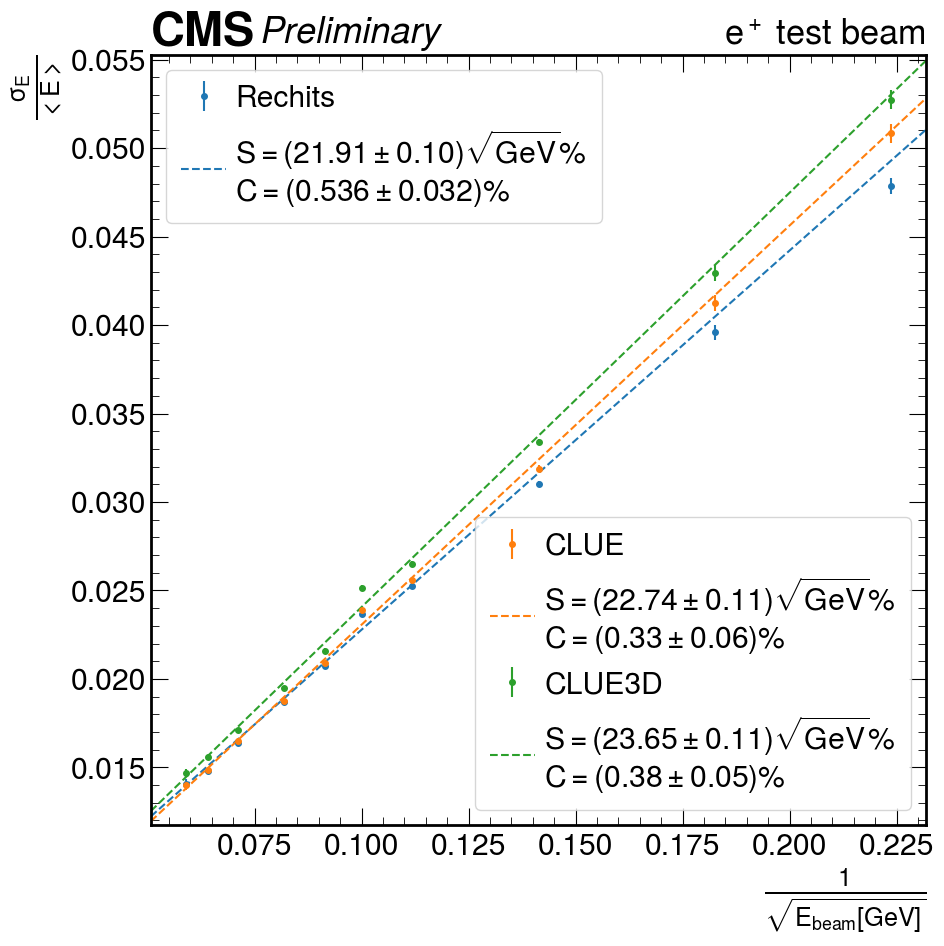

In [27]:
plotSigmaOverMean(fitResults["data"], xMode="E")
plotSigmaOverMean(fitResults["data"], xMode="1/sqrt(E)", plotFit=True, plotPaperFit=False, linkPointsWithLines=False, markersize=4)

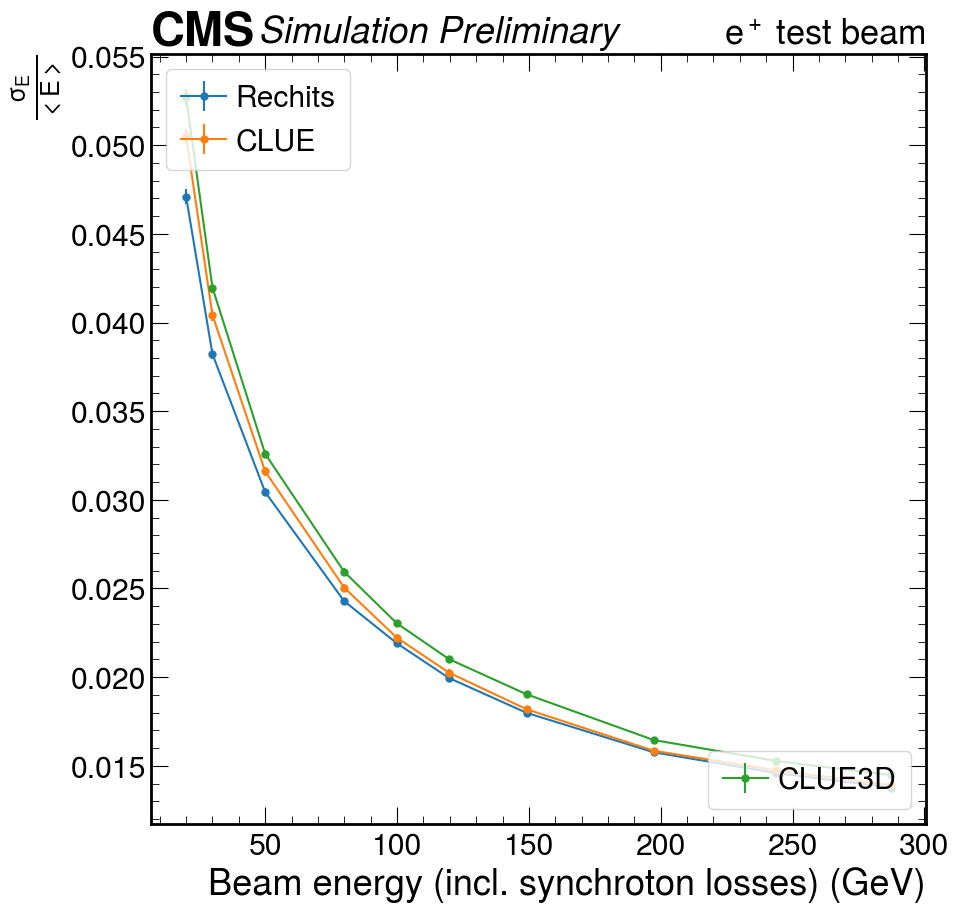

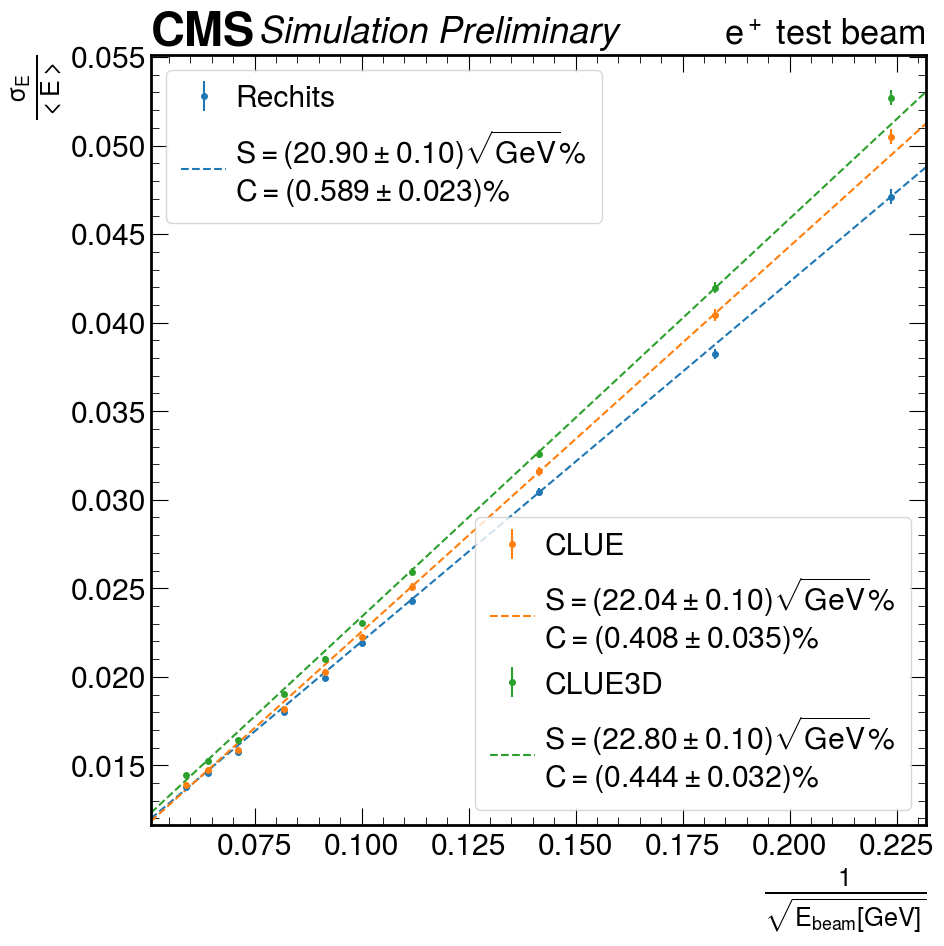

In [28]:
plotSigmaOverMean(fitResults["sim_proton_v46_patchMIP"], xMode="E", sim=True)
plotSigmaOverMean(fitResults["sim_proton_v46_patchMIP"], xMode="1/sqrt(E)", sim=True, plotFit=True, plotPaperFit=False, linkPointsWithLines=False, markersize=4)

In [16]:
fitRes = fit(fitResults["data"]["rechit"])
fitRes

EResolutionFitResult(S=0.21905076401453624+/-0.001030558917426485, C=0.005360336469628157+/-0.0003197451451375701)

In [17]:
# Taken from https://github.com/botprof/plotting-uncertainty-ellipses/blob/main/plotting-uncertainty-ellipses.ipynb
def plotEllipse(x:uncertainties.ufloat, y:uncertainties.ufloat, cl:float=0.95, ellipse_kwargs:dict=dict()) -> matplotlib.patches.Ellipse:
    cov = uncertainties.covariance_matrix([x, y])
    W, V = np.linalg.eig(cov)
    j_max = np.argmax(W)
    j_min = np.argmin(W)
    s = scipy.stats.chi2.isf(1-cl, 2) # 1-confidence level, 2 degrees of freedom
    return matplotlib.patches.Ellipse(
        (x.nominal_value, y.nominal_value),
        2.0 * np.sqrt(s * W[j_max]),
        2.0 * np.sqrt(s * W[j_min]),
        angle=np.arctan2(V[j_max, 1], V[j_max, 0]) * 180 / np.pi,
        **ellipse_kwargs
    )

In [18]:
def plotFitResults():
    fig, ax = plt.subplots()
    
    def plotPoint(fitRes, level):
        S_scaled, C_scaled = fitRes.S*100, fitRes.C*100
        x, y = S_scaled.nominal_value, C_scaled.nominal_value
        label = levelLabelMap[level]
        color = levelColorMap[level]
        ax.plot([x], [y], ".", label=label, color=color)
        ax.add_patch(plotEllipse(S_scaled, C_scaled, ellipse_kwargs=dict(color=color, alpha=0.5)))
        ax.annotate(label, xy=(x, y))
    #fitRes = fit(fitResults["data"]["rechit"])
    plotPoint(paperResolution_data, "paper")
    for fitRes, label in [(fitResults["data"]["rechit"], "rechit"), (fitResults["data"]["clue"], "clue"), (fitResults["data"]["clue3D"], "clue3D")]:
        fitRes = fit(fitRes)
        plotPoint(fitRes, level=label)
    
    #$S = ({fitRes.S*100:L})" r"\sqrt{GeV} \%$" "\n" f"$C = ({fitRes.C*100:L}) \%$"
    ax.set_xlabel(r"$S (\sqrt{GeV} \%)$")
    ax.set_ylabel(r"C (%)")
    ax.legend()

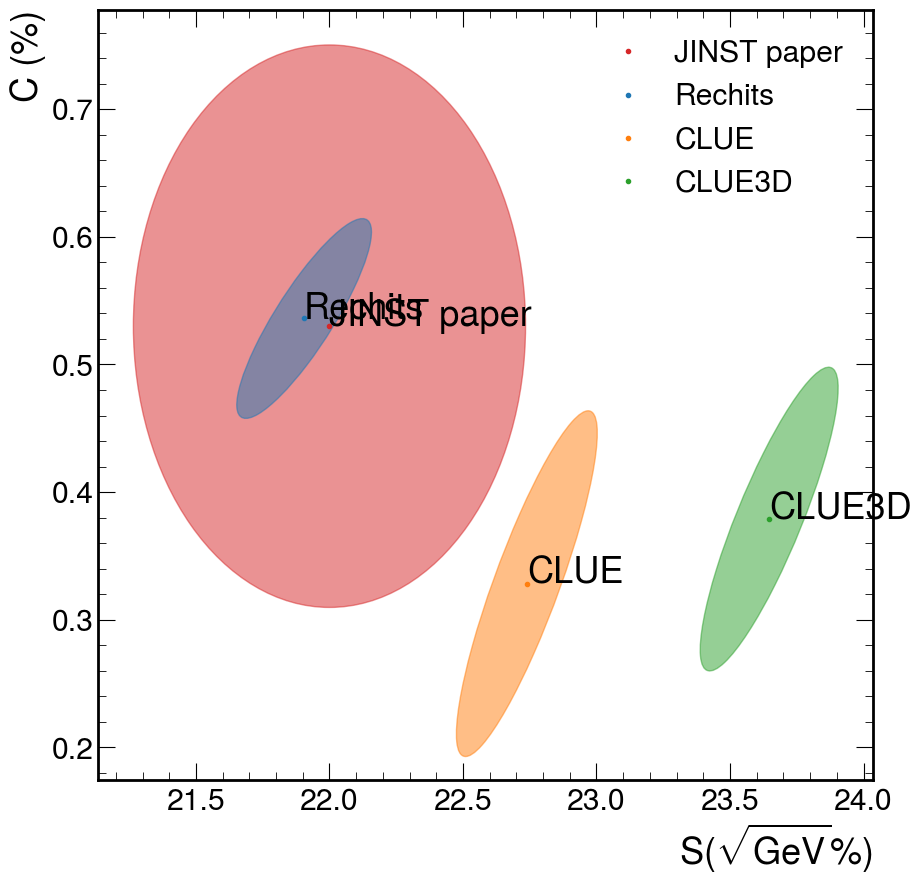

In [19]:
plotFitResults()